In [45]:
# BASIC DS LIBS
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# FILE IO LIBS
import os 
from os.path import join 

# GEOSPATIAL LIBS
from osgeo import gdal
import geopandas as gpd
import geopy
from geopandas import GeoDataFrame

# PLOT LIBS
import plotly.express as px 
from plotly.offline import plot
import plotly.graph_objects as go
from shapely.geometry import Point
from plotly.subplots import make_subplots


In [46]:
# IMPORT DATA
hunger_data = pd.read_csv(r'data/foodlink_data.csv')
mealmap_data = pd.read_excel(r'data/MMG2022_2020-2019Data_ToShare.xlsx')
gun_data = pd.read_csv(r'data/Rochester_NY_Shooting_Victims.csv')

### EDA

#### DATA CLEANING

In [47]:
gun_data.head()
print(gun_data.columns)
print(gun_data.count())

Index(['X', 'Y', 'ID', 'Case_Number', 'Address', 'Occurred_Date',
       'Occurred_Month', 'Occurred_Year', 'Crime_Type', 'Multiple_Shooting',
       'Gender', 'Race', 'Ethnicity', 'Victim_Age', 'Victim_Age_Band',
       'Latitude', 'Longitude', 'ObjectId'],
      dtype='object')
X                    4679
Y                    4679
ID                   4679
Case_Number          4679
Address              4679
Occurred_Date        4679
Occurred_Month       4679
Occurred_Year        4679
Crime_Type           4679
Multiple_Shooting    4679
Gender               4679
Race                 4679
Ethnicity            4679
Victim_Age           4679
Victim_Age_Band      4679
Latitude             4679
Longitude            4679
ObjectId             4679
dtype: int64


In [48]:
# GUN DATA CLEANING
gun_data = gun_data.drop(columns=[
                        'ID',
                        'Case_Number',
                        'Occurred_Month',
                        'Gender',
                        'Race',
                        'Ethnicity',
                        'Victim_Age',
                        'Victim_Age_Band',
                        'ObjectId',
                        'Multiple_Shooting'
                        ])

gun_data = gun_data.loc[gun_data['Occurred_Year'].isin([2022,2023])]                        
print(gun_data.info())  # to check for any missing values
gun_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137 entries, 0 to 436
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   X              137 non-null    float64
 1   Y              137 non-null    float64
 2   Address        137 non-null    object 
 3   Occurred_Date  137 non-null    object 
 4   Occurred_Year  137 non-null    int64  
 5   Crime_Type     137 non-null    object 
 6   Latitude       137 non-null    float64
 7   Longitude      137 non-null    float64
dtypes: float64(4), int64(1), object(3)
memory usage: 9.6+ KB
None


,X,Y,Address,Occurred_Date,Occurred_Year,Crime_Type,Latitude,Longitude
0,-77.610890,43.184163,442 Remington St,2022/06/01 04:00:00+00,2022,Shooting,43.184163,-77.610890
1,-77.598893,43.181793,904 Hudson Ave,2022/05/29 04:00:00+00,2022,Homicide,43.181793,-77.598893
2,-77.630378,43.142970,168 Bartlett St,2022/05/29 04:00:00+00,2022,Shooting,43.142970,-77.630378
3,-77.580628,43.167216,720 N Goodman St,2022/05/28 04:00:00+00,2022,Shooting,43.167216,-77.580628
4,-77.641972,43.162394,138 Murray St,2022/05/26 04:00:00+00,2022,Shooting,43.162394,-77.641972


In [49]:
# HUNGER DATA
hunger_data.columns = ['Zip Code', 'Latitude', 'Longitude', 'Food Insecurity']

# NARROW DOWN DATA TO JUST ROCHESTER AREAS
roc_zip = list(range(14604, 14624))
roc_zip.append(14626)
roc_zip.append(14627)
roc_zip.append(14642)
hunger_data = hunger_data.loc[hunger_data['Zip Code'].isin(roc_zip)]

print(hunger_data.info())   # to check for missing values
hunger_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 124 to 145
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Zip Code         20 non-null     int64  
 1   Latitude         20 non-null     float64
 2   Longitude        20 non-null     float64
 3   Food Insecurity  20 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 800.0 bytes
None


,Zip Code,Latitude,Longitude,Food Insecurity
124,14626,43.2141,-77.7135,0.094
127,14623,43.0881,-77.6425,0.167
128,14622,43.2138,-77.5569,0.080
129,14621,43.1863,-77.6018,0.298
130,14620,43.1291,-77.6065,0.187


In [50]:
# PLOTTING BOTH CONTINUOUS, NUMERIC VARS
gun_plot = px.scatter_mapbox(
                        data_frame = gun_data,
                        lat = gun_data['Latitude'],
                        lon = gun_data['Longitude'],
                        color= gun_data['Crime_Type'],    # TODO: replace with our metric
                        text = gun_data['Crime_Type'],    # TODO: replace with our metric
                        hover_name = None,
                        hover_data= [gun_data['Occurred_Date'],gun_data['Address']],
                        zoom = 10,
                        mapbox_style = 'open-street-map',
                        title='Gun Violence Incidents by Zipcode',
                        height = 400,
                        width = 700
                        )



hunger_plot = px.scatter_mapbox(
                        data_frame = hunger_data,
                        lat = hunger_data['Latitude'],
                        lon = hunger_data['Longitude'],
                        color= hunger_data['Food Insecurity'],
                        zoom = 10,
                        hover_data = [hunger_data['Food Insecurity'],
                                      hunger_data['Zip Code']],
                                      
                        size = hunger_data['Food Insecurity'],
                        mapbox_style = 'open-street-map',
                        title='Rochester Zip Codes by Food Insecurity Rate',
                        height = 400,
                        width = 700,
                        color_continuous_scale='RdYlGn_r'
                )

gun_plot.show()
hunger_plot.show()

#### SUMMARY STATS OF EACH DATASET

In [51]:
# GET STATS
gun_stats = gun_data.describe()
hunger_stats = gun_data.describe()

# PRINT STATS
print("GUN VIOLENCE BASIC STATS:")
print(gun_stats, "\n")
print("HUNGER BASIC STATS:")
print(hunger_stats)

GUN VIOLENCE BASIC STATS:
                X           Y  Occurred_Year    Latitude   Longitude
count  137.000000  137.000000          137.0  137.000000  137.000000
mean   -77.615400   43.167202         2022.0   43.167202  -77.615400
std      0.024012    0.015374            0.0    0.015374    0.024012
min    -77.659312   43.123608         2022.0   43.123608  -77.659312
25%    -77.632012   43.159877         2022.0   43.159877  -77.632012
50%    -77.621639   43.169126         2022.0   43.169126  -77.621639
75%    -77.599577   43.177143         2022.0   43.177143  -77.599577
max    -77.552548   43.220375         2022.0   43.220375  -77.552548 

HUNGER BASIC STATS:
                X           Y  Occurred_Year    Latitude   Longitude
count  137.000000  137.000000          137.0  137.000000  137.000000
mean   -77.615400   43.167202         2022.0   43.167202  -77.615400
std      0.024012    0.015374            0.0    0.015374    0.024012
min    -77.659312   43.123608         2022.0   43.12360

### COMPARING DATASETS AND VARIABLES

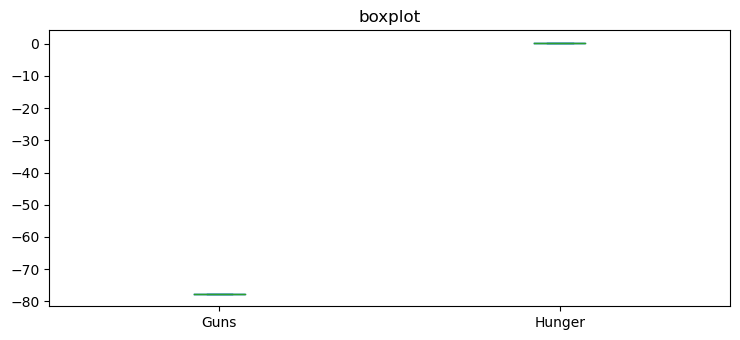

In [52]:
# COMPARE BY BOXPLOT

# GET DATA
gun_boxplot_data = gun_data['X'].quantile([0.25,0.5,0.75])   # TODO: change this to gun rate once done
hunger_boxplot_data = hunger_data['Food Insecurity'].quantile([0.25,0.5,0.75])
boxplots = pd.DataFrame({'Guns': gun_boxplot_data, 'Hunger': hunger_boxplot_data})

# SET FIGURE 
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Plot the dataframe
ax = boxplots[['Guns','Hunger']].plot(kind='box', title='boxplot')

# Display the plot
plt.show()

<Axes: title={'center': 'box'}>

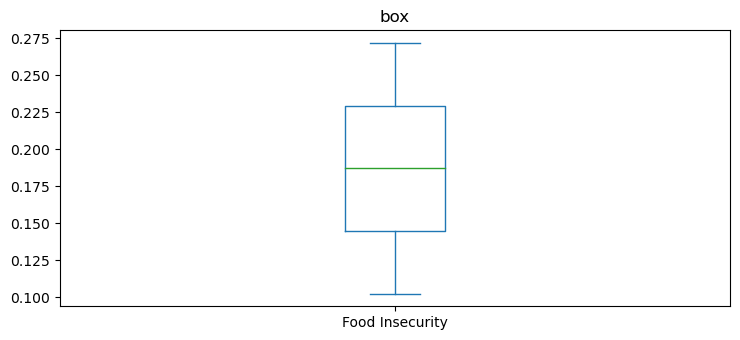

In [53]:
hunger_boxplot_data = hunger_data['Food Insecurity'].quantile([0.25,0.5,0.75])

hunger_boxplot_data.plot(kind="box",title='box')

#### MAKING OUR GUN DATA METRIC

In [54]:
gun_data.head()

,X,Y,Address,Occurred_Date,Occurred_Year,Crime_Type,Latitude,Longitude
0,-77.610890,43.184163,442 Remington St,2022/06/01 04:00:00+00,2022,Shooting,43.184163,-77.610890
1,-77.598893,43.181793,904 Hudson Ave,2022/05/29 04:00:00+00,2022,Homicide,43.181793,-77.598893
2,-77.630378,43.142970,168 Bartlett St,2022/05/29 04:00:00+00,2022,Shooting,43.142970,-77.630378
3,-77.580628,43.167216,720 N Goodman St,2022/05/28 04:00:00+00,2022,Shooting,43.167216,-77.580628
4,-77.641972,43.162394,138 Murray St,2022/05/26 04:00:00+00,2022,Shooting,43.162394,-77.641972


In [55]:
# import Nominatim
from geopy.geocoders import Nominatim

# PREPROCESSING TOOLS AND DATA
geolocator = Nominatim(user_agent='myapplication')
gun_coords = gun_data[['Latitude','Longitude']]
#print(gun_coords)

# CREATE OUR CONVERTER 
zipcode=[]
gun_lat = gun_data["Latitude"].tolist()
gun_long=gun_data["Longitude"].tolist()
for i in range(len(gun_lat)):
    location = geolocator.reverse((gun_lat[i],gun_long[i]),timeout=10)
    address = location.raw['address']
    zipcode.append(address.get('postcode')) 

zipcode = pd.Series(zipcode)

gun_data['Zip_Code'] = zipcode

gun_data.head()

,X,Y,Address,Occurred_Date,Occurred_Year,Crime_Type,Latitude,Longitude,Zip_Code
0,-77.610890,43.184163,442 Remington St,2022/06/01 04:00:00+00,2022,Shooting,43.184163,-77.610890,14621
1,-77.598893,43.181793,904 Hudson Ave,2022/05/29 04:00:00+00,2022,Homicide,43.181793,-77.598893,14621
2,-77.630378,43.142970,168 Bartlett St,2022/05/29 04:00:00+00,2022,Shooting,43.142970,-77.630378,14611
3,-77.580628,43.167216,720 N Goodman St,2022/05/28 04:00:00+00,2022,Shooting,43.167216,-77.580628,14609
4,-77.641972,43.162394,138 Murray St,2022/05/26 04:00:00+00,2022,Shooting,43.162394,-77.641972,14606


In [ ]:
gun_count = gun_data.groupby(["Zip_code"])["X"].count().reset_index(name="count")